In this notebook:

Fig 3 STRAND prediction

SI global thermodynamic folding

In [1]:
# %load /Users/hwayment/ipynb_defaults.py
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

from arnie.mfe import mfe
from arnie.pfunc import pfunc
from arnie.bpps import bpps
from ipynb.draw import draw_struct
from RiboGraphViz import RGV
openai  ='open -a "Adobe Illustrator"'
import eternabench as eb


Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('../scoring_data/S-Processed-TES_metadata_plus_scores.csv')

In [3]:
pkgs = [x.split(' ')[0] for x in df.keys() if x.endswith('F-score')]

id_vars = ['SSTRAND_ID', 'TYPE', 'EXT_SOURCE', 'EXT_ID', 'ORGANISM']
reshaped_df = pd.DataFrame()

for i, metric in enumerate(['Sens', 'PPV', 'F-score']):
    keys = list([x for x in df.keys() if x.endswith(metric)])
    tmp = df[id_vars+keys]
    tmp2 = tmp.melt(id_vars=id_vars)
    tmp2['package'] = [x.split(' ')[0] for x in tmp2['variable']]
    tmp2[metric] = tmp2['value']
    tmp2 = tmp2.drop(columns=['variable','value'])
    if i==0:
        reshaped_df = tmp2
    else:
        reshaped_df = pd.concat([reshaped_df,tmp2[[metric]]],axis=1)

reshaped_df['bs_ind'] = [x for x in range(974)]*9

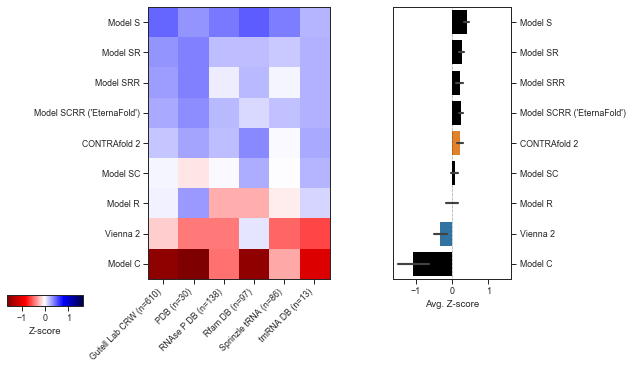

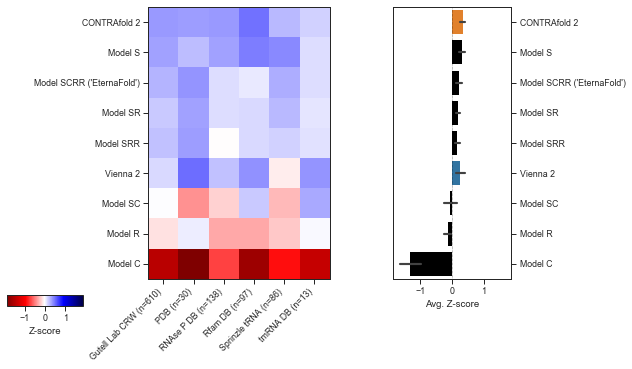

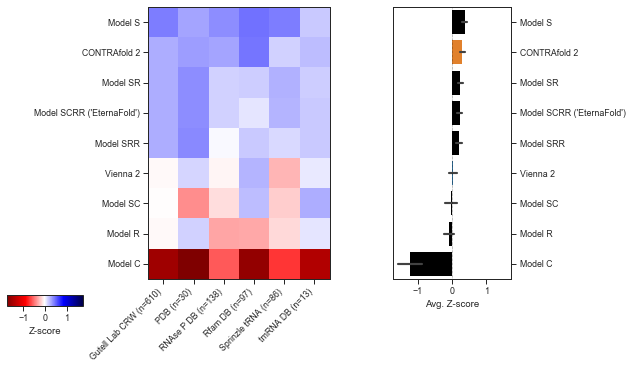

In [5]:
dataset_labels=['Gutell Lab CRW (n=610)', 'PDB (n=30)', 'RNAse P DB (n=138)', 'Rfam DB (n=97)', 'Sprinzle tRNA (n=86)', 'tmRNA DB (n=13)']

for i, metric in enumerate(['Sens', 'PPV', 'F-score']):
    zscores, ranking = eb.stats.calculate_Z_scores(reshaped_df,dataset_field='EXT_SOURCE', metric=metric)
    
    package_order = list(ranking.package)[::-1]

    eb.plot.ranked_heatmap(zscores, ranking, package_order=package_order, dataset_field='EXT_SOURCE',metric=metric+'_zscore_by_EXT_SOURCE_mean',dataset_labels=dataset_labels)
    #savefig('FIGURES/3/STRAND_TES_heamap_%s.pdf' % metric,bbox_inches='tight')


In [6]:
zscores.to_csv('../scoring_data/STRAND_Fscore_by_dataset.csv',index=False)

In [17]:
tmp = df.melt(id_vars=['SSTRAND_ID', 'TYPE', 'EXT_SOURCE', 'EXT_ID', 'ORGANISM'])

for pkg in pkgs:
    tmp2 = tmp.loc[tmp.variable.str.contains(pkg)]
    tmp['metric'] = [x]

,SSTRAND_ID,TYPE,EXT_SOURCE,EXT_ID,ORGANISM,variable,value
0,ASE_00005,Ribonuclease P RNA,RNase P Database,A.eutrophus.ct,Ralstonia eutrophus,contrafold_2 Sens,0.800000
1,ASE_00007,Ribonuclease P RNA,RNase P Database,A.ferrooxidans-g.ct,Acidothiobacillus ferrooxidans,contrafold_2 Sens,0.555556
2,ASE_00010,Ribonuclease P RNA,RNase P Database,A.laidlawii.ct,Acholeplasma laidlawii,contrafold_2 Sens,0.356164
3,ASE_00012,Ribonuclease P RNA,RNase P Database,A.nidulans.ct,Synechococcus sp.,contrafold_2 Sens,0.388889
4,ASE_00012,Ribonuclease P RNA,RNase P Database,A.nidulans.ct,Synechococcus sp.,contrafold_2 Sens,0.000000
...,...,...,...,...,...,...,...
26293,PDB_00205,Viral & Phage RNA,RCSB Protein Data Bank,1rfr,COXSACKIEVIRUS B3,eternafold_G F-score,0.953463
26294,PDB_00213,Synthetic RNA,RCSB Protein Data Bank,1s9s,SYNTHETIC,eternafold_G F-score,0.942809
26295,PDB_00216,Group I Intron,RCSB Protein Data Bank,1slo,CAENORHABDITIS ELEGANS,eternafold_G F-score,1.000000
26296,PDB_00227,Synthetic RNA,RCSB Protein Data Bank,1wts,BACILLUS STEAROTHERMOPHILUS,eternafold_G F-score,1.000000


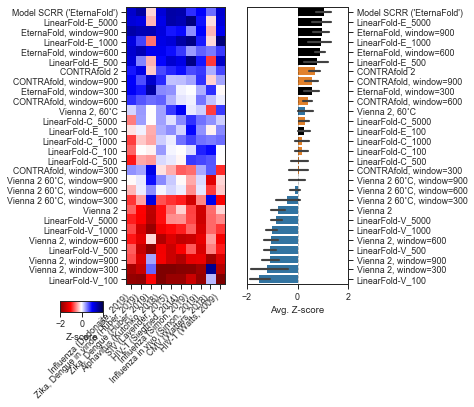

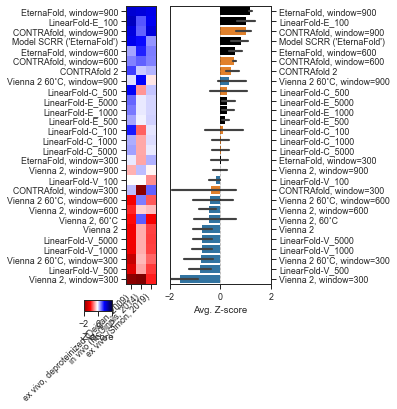

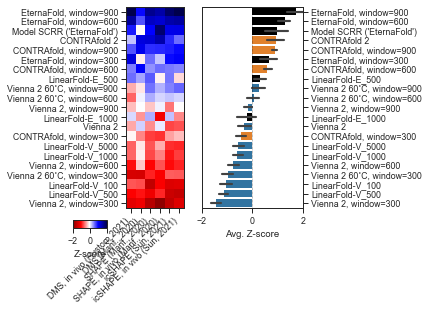

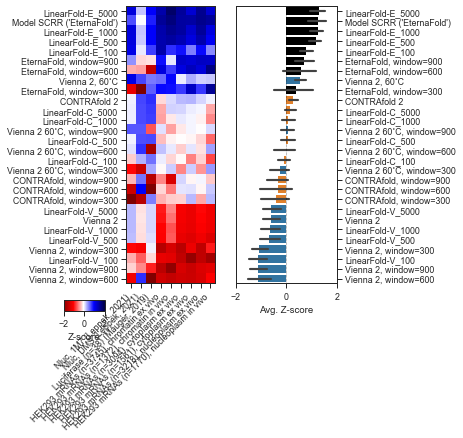

In [8]:
df = pd.read_json('thermodynamic_global_folding_data.json.zip')
tmp1 = df.loc[~df.package.str.contains('LinearFold')]

tmp2 = df.loc[df.package.str.contains('LinearFold')]
tmp2 = tmp2.loc[~tmp2.package.str.contains('window')]

df = tmp1.append(tmp2, ignore_index=True)


types=['viral_gRNA', 'rRNA', 'SARS-CoV-2_gRNA', 'mRNA',]

for i, rna in enumerate(types):

    if rna=='SARS-CoV-2_gRNA':
        zscores, ranking = eb.stats.calculate_Z_scores(df.loc[df.Class==rna][~df.package.isin(['LinearFold-E_100','LinearFold-E_5000','vienna_2_60C'])])
        
    else:
        zscores, ranking = eb.stats.calculate_Z_scores(df.loc[df.Class==rna])
        
    n=len(zscores.Dataset.unique())
    k = len(zscores.package.unique())
    
    eb.plot.ranked_heatmap(zscores, ranking, vmin=-2,vmax=2,figsize=(.2*n+2,.2*k-0.5),width_ratios=[.2*n, 2],ext=True)
    savefig('FIGURES/SI/global_thermo_ranking_%s.pdf' % rna, bbox_inches='tight')
    